### Nút hồi tiếp có cổng GRU
- Ta đã thảo luận cách tính gradient trong mạng nơ ron hồi tiếp, cụ thể ta đã biết rằng tích của một chuỗi dài các ma trận có thể dẫn đến việc gradient tiêu biến hoặc bùng nổ. Hãy điểm qua các tình huống thực tế thể hiện rõ hai bất trường đó
    1. Ta có thể gặp tình huống mà những quan sát xuất hiện sớm có thể ảnh hưởng lớn đến việc dự đoán toàn bộ những quan sát trong tương lai. Ví dụ như quan sát đầu tiên chứa giá trị tổng kiểm và mục tiêu là kiểm tra xem liệu giá trị tổng kiểm đó có đúng không ở cuỗi chuỗi. Trong trường hợp này, ảnh hưởng của token đầu tiên là rất quan trọng. __Do đó, ta muốn có cơ chế để lưu trữ những thông tin quan trọng ban đầu trong ô nhớ.__ Nếu không, ta sẽ phải gán một giá trị gradient rất lớn cho quan sát ban đầu vó nó ảnh hưởng đến toàn bộ các quan sát tiếp theo.
    2. Một tình huống khác là khi một vài ký hiệu không chứa thông  tin phù hợp. Ví dụ như khi phân tích một trang web, ta có thể gặp các mã HTML không giúp ích gì cho việc xác định thông tin được truyền tải. Do đó, ta cũng muốn có __cơ chế để bỏ qua những ký hiệu như vậy trong các biểu diễn trạng thái tiềm ẩn.__
    3. Ta cũng có thể gặp những khoảng ngắt giữa các phần trong một chuỗi. Ví dụ như những phần chuyển tiếp giữa các chương của một quyển sách, hay chuyển biến xu hướng giữa thị trường giá lên và thị trường giá xuống trong chứng khoán. Trong trường hợp này, __sẽ tốt hơn nếu có một cách để xóa hay đặt lại các biểu diễn trạng thái ẩn về giá trị ban đầu.__
- Nhiều phương pháp đã được đề xuất để giải quyết vấn đề trên. Một trong những phương pháp ra đời sớm nhất là LSTM (Long short term memory). Nút hồi tiếp có cổng (Gated Recurrent Unit - GRU) là một biến thể gon hơn của LSTM, thường có chất lượng tương đương và tính toán nhanh hơn đáng kể. 

#### 1. Kiểm soát trạng thái ẩn

Sự khác biệt chính giữa RNN thông thường và GRU là GRU hỗ trợ việc kiểm soát trạng thái ẩn. Điều này có nghĩa là __ta có các cơ chế được học để quyết định khi nào nên cập nhật và khi nào thì nên xóa trạng thái ẩn.__ Ví dụ, nếu ký tự đầu tiên có mức độ quan trọng cao, mô hình sẽ học để không cập nhật trạng thái ẩn sau lần quan sát đầu tiên. Tương tự, mô hình sẽ học các bỏ qua những quan sát tạm thời không liên quan, cũng như cách xóa trạng thái ẩn khi cần thiết.

##### 1.1 Cổng xóa và Cổng cập nhật

Đầu tiên ta giới thiệu cổng xóa và cổng cập nhật, ta thiết kế chúng thành các vecto có các phần tử trong khoảng (0, 1) để có thể biểu diễn các tổ hợp lồi. Chẳng hạn, một biến xóa cho phép kiểm soát bao nhiều phần tử của trạng thái trước đây được giữ lại. Tương tự, một biến cập nhật cho phép kiểm soát bao nhiêu phần của trạng thái mới sẽ giống như trạng thái cũ.

- Ta bắt đầu bằng việc thiết kế các cổng tạo ra các biến này. Hính dưới minh họa đầu vào cho cả cổng xóa và cổng cập nhật trong GRU với đầu vào ở bước thời gian hiện tại và trạng thái ẩn ở bước thời gian trước đó là H_(t - 1). Đầu ra được tạo bởi một tầng kết nối đầy đủ với hàm kích hoạt sigmoid.

    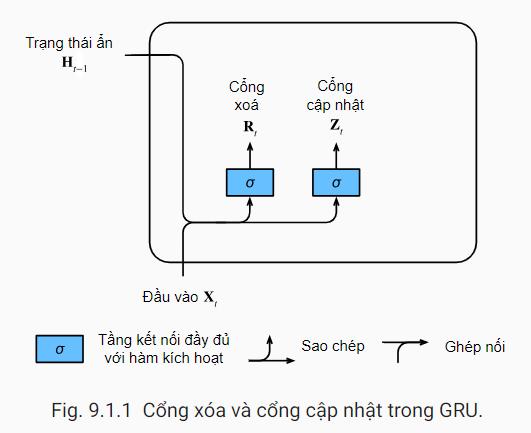

- Tại bước gời gian t, với đầu vào minibatch là X_t với kích thước (n x d) với n là kích thước minibatch, d là số lượng đầu vào. Và trạng thái ẩn ở bước thời gian gần nhất là H_(t - 1) với kích thước (n x h) với h là số lượng trạng thái ẩn. Cổng xóa R_t (n x h) và cổng cập nhật Z_t (n x h) được tính như sau:
        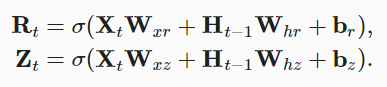

- Ở đây, W_xr (d x h) và W_hr, W_hz (h x h) là các tham số trọng số và b_r, b_z (1, h) là các hệ số điều chỉnh. Ta sẽ sử dụng hàm sigmoid để biến đổi các giá trị đầu vào nằm trong khoảng (0, 1).

#### 1.2 Hoạt động của cổng xóa
- Ta bắt đầu bằng việc tích hợp cổng xóa với một cơ chế cập nhật trạng thái tiềm ẩn thông thường. Trong RNN, ta cập nhật trạng thái ẩn theo công thức:
    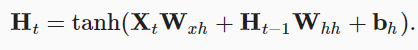
- Ta sử dụng hàm tanh để đảm bảo rằng các giá trị trạng thái ẩn nằm trong khoảng (-1, 1). Nếu muốn giảm ảnh hưởng của các trạng thái trước đó, ta có thể nhân H_(t - 1) với R_t theo từng phần tử. 
    + Nếu các phần tử trong cổng xóa R_t có giá trị gần với 1 thì kết quả sẽ giống RNN thông thường
    + Nếu các phần tử trong cổng xóa R_t có giá trị gần với 0 thì trạng thái ẩn sẽ là đầu ra của một perceptron đa tầng với đầu vào là X_t. Và bất kỳ trạng thái ẩn nào tồn tại trước đó đều được đặt lại về giá trị mặc định. 
- Tại đây nó được gọi là trạng thái ẩn tiềm năng và chỉ là tiềm năng vì ta cần kết hợp thêm đầu ra của cổng cập nhật.
    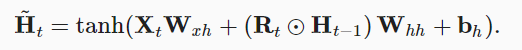

    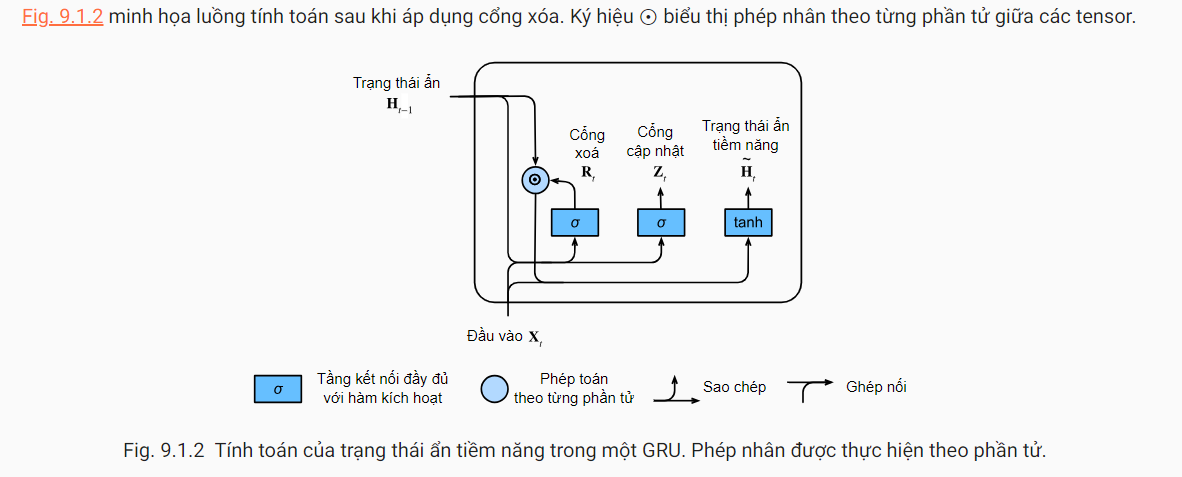

#### 1.3 Hoạt động của cổng cập nhật
- Tiếp theo ta sẽ kết hợp hiệu ứng của cổng cập nhật Z. Cổng này xác định mức độ giống nhau giữa trạng thái mới H_t và trạng thái cũ H_(t - 1), cũng như mức độ trạng thái ẩn tiềm năng 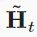 được sử dụng. Biến cổng Z_t được sử dụng cho mục đích này, bằng cách áp dụng tổ hợp lồi giữa trạng thái cũ và trạng thái mới. Ta có phương trình cập nhật cuối cùng cho GRU.

    
    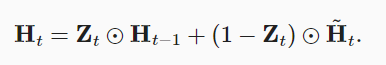

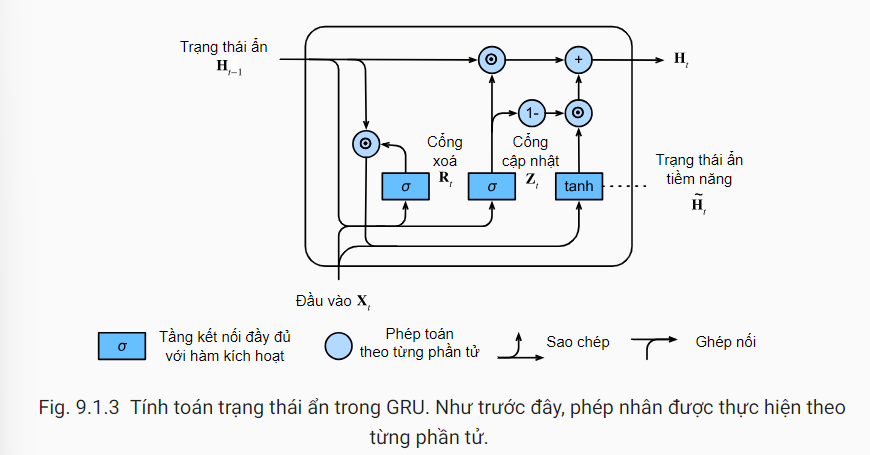

- Nếu các giá trị trong cổng cập nhật Z_t bằng 1, chúng ta chỉ cần đơn giản giữ lại trạng thái cũ. Trong trường hợp này, thông tin từ X_t về cơ bản được bỏ qua, tương đương với việc bỏ qua bước thời gian t trong chuỗi phụ thuộc.
- Ngược lại, nếu Z_t gần 0 thì trạng thái ẩn H_t sẽ gần với trạng thái ẩn tiềm năng 
- Những thiết kế trên ó thể giúp ta giải quyết vấn đề tiêu biến gradient trong các mạng RNN và nắm bắt tốt hơn sự phụ thuộc xa trong chuối thời gian. 

- Tóm lại, mạng GRU có hai tính chất nổi bật như sau:
    1. __Cổng xóa giúp nắm bắt các phụ thuộc ngắn hạn trong chuỗi thời gian__
    2. __Cổng cập nhật giúp nắm bắt các phụ thuộc dài hạn trong chuỗi thời gian__